#PROJECT

In [1]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:


# Effettua la richiesta GET all'API TfL
url = "https://api.tfl.gov.uk/AccidentStats/2019"  # Cambia l'anno a seconda dei dati che vuoi
response = requests.get(url)

# Carica la risposta in formato JSON
data = response.json()

# Converte il JSON in un DataFrame di pandas
df = pd.json_normalize(data)

# Salva il DataFrame in formato CSV
# df.to_csv('incidenti_tfl_2019.csv', index=False)

In [3]:
# Explode the casualties column
df_exploded = df.explode('casualties')
# Normalize the casualties field
casualties_df = pd.json_normalize(df_exploded['casualties'])
# Combine the normalized casualties back with the original data
df_exploded = df_exploded.drop(columns=['casualties']).reset_index(drop=True)
df_combined = pd.concat([df_exploded, casualties_df], axis=1)
# Extract ages
ages = casualties_df['age'].dropna().tolist()

# Display results
print("Extracted ages:", ages[:10])  # Display the first 10 ages
print("Lenght of ages: ", len(ages))

Extracted ages: [20.0, 29.0, 48.0, 23.0, 24.0, 18.0, 69.0, 38.0, 42.0, 35.0]
Lenght of ages:  57116


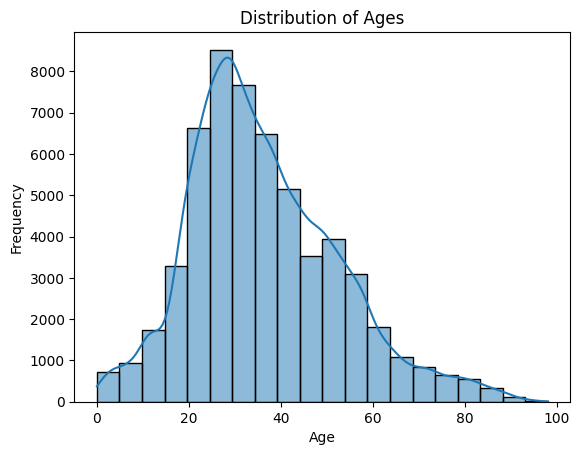

In [4]:
sns.histplot(ages, bins=20, kde=True)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Distribution of Ages")
plt.show()


In [5]:
age_ranges = {
    "0-17": 0,
    "18-25": 0,
    "26-40": 0,
    "41-65": 0,
    "65+": 0
}
for age in ages:
    if age <= 17:
        age_ranges["0-17"] += 1
    elif age <= 25:
        age_ranges["18-25"] += 1
    elif age <= 40:
        age_ranges["26-40"] += 1
    elif age <= 65:
        age_ranges["41-65"] += 1
    else:
        age_ranges["65+"] += 1

print(age_ranges)

{'0-17': 4730, '18-25': 10214, '26-40': 22162, '41-65': 16916, '65+': 3094}


In [6]:
bins, bin_edges = pd.qcut(ages, q=5, labels=["0-23", "24-30", "31-38", "39-50", "50+"], retbins=True)
print("Bin Edges:", bin_edges)
print("Bins:", bins)
print(bins.value_counts())

Bin Edges: [ 0. 23. 30. 38. 50. 98.]
Bins: ['0-23', '24-30', '39-50', '0-23', '24-30', ..., '31-38', '39-50', '31-38', '0-23', '24-30']
Length: 57116
Categories (5, object): ['0-23' < '24-30' < '31-38' < '39-50' < '50+']
0-23     11764
24-30    11744
31-38    11230
39-50    11648
50+      10730
Name: count, dtype: int64


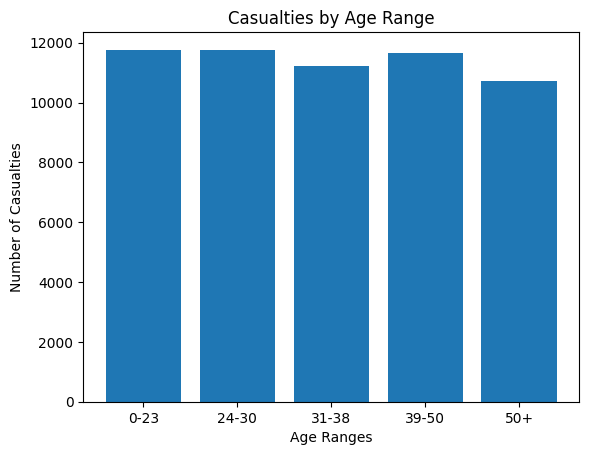

In [7]:
age_ranges = ["0-23", "24-30", "31-38", "39-50", "50+"]
counts = [11764, 11744, 11230, 11648, 10730]

plt.bar(age_ranges, counts)
plt.xlabel("Age Ranges")
plt.ylabel("Number of Casualties")
plt.title("Casualties by Age Range")
plt.show()

In [8]:
# Assume df is your original DataFrame
# Explode the casualties column to work with individual casualties
df_exploded = df.explode('casualties')

# Normalize the casualties field to extract age
casualties_df = pd.json_normalize(df_exploded['casualties'])
df_exploded = df_exploded.reset_index(drop=True)
df_combined = pd.concat([df_exploded, casualties_df[['age']]], axis=1)

# Define a function to count casualties in each range
def count_age_ranges(group):
    age_counts = {
        "casualty_age_0-23": sum(group['age'] <= 23),
        "casualty_age_24-30": sum((group['age'] > 23) & (group['age'] <= 30)),
        "casualty_age_31-38": sum((group['age'] > 30) & (group['age'] <= 38)),
        "casualty_age_39-50": sum((group['age'] > 38) & (group['age'] <= 50)),
        "casualty_age_50+": sum(group['age'] > 50)
    }
    return pd.Series(age_counts)

# Group by accident ID and apply the function
age_range_counts = df_combined.groupby('id').apply(count_age_ranges).reset_index()

# Merge the counts back to the original DataFrame
df_with_age_ranges = df.merge(age_range_counts, on='id', how='left')


/var/folders/ng/j8jl9k617sn7s0kcxvhp9ctm0000gn/T/ipykernel_61043/3119443689.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_range_counts = df_combined.groupby('id').apply(count_age_ranges).reset_index()


In [9]:
age_range_counts.head()

,id,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345828,0,0,0,0,1
1,345829,0,1,0,0,0
2,345830,1,0,0,0,0
3,345831,0,0,0,0,1
4,345832,1,0,0,1,0


In [10]:
age_range_counts.to_csv('age_range_counts_to_merge.csv', index=False)

In [ ]:
df_ages = pd.read_csv("age_range_counts_to_merge.csv")
df_merged = df.merge(df_ages, on='id', how='left')